 ORB feature matching

Best stitching order determined: [0, 6, 8, 3, 2, 4, 5, 1, 9, 7]
Đang ghép ảnh...


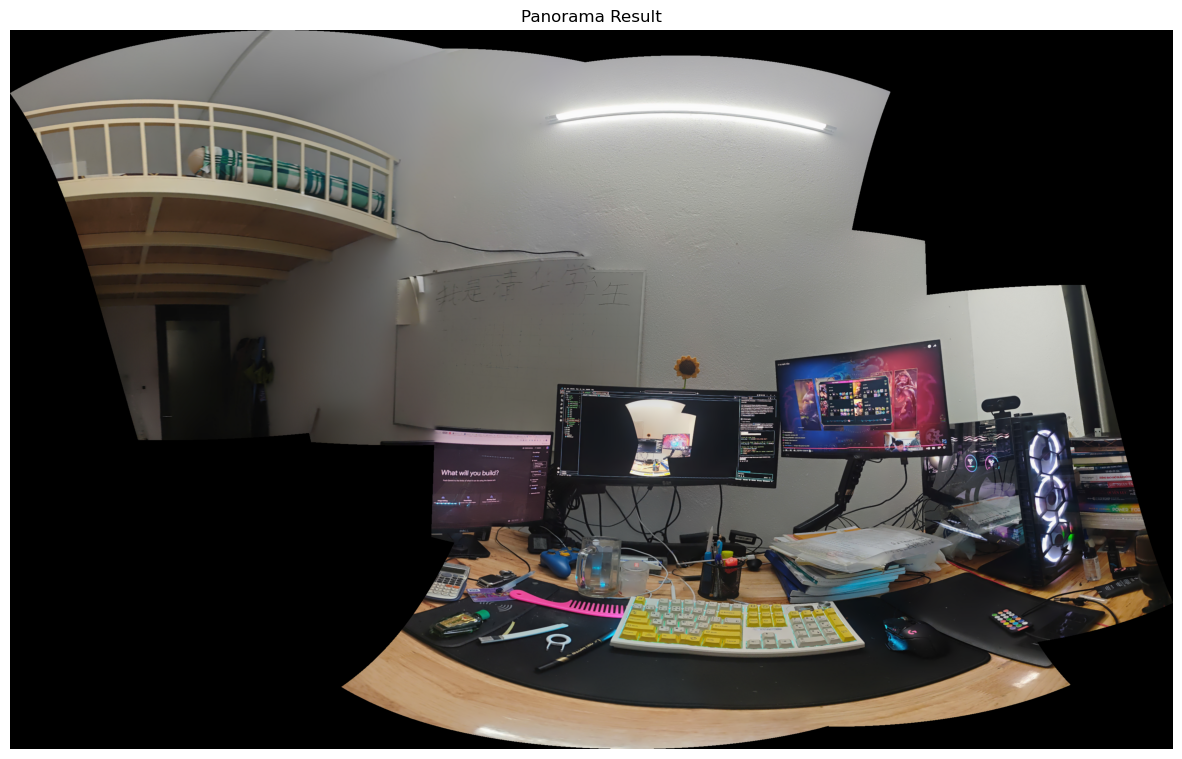

Kết quả đã được lưu vào 'panorama_result.jpg'


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations

def find_best_stitch_order(images):
    """Determine the best order to stitch images based on feature matching strength"""
    if len(images) <= 2:
        return list(range(len(images)))
    
    # Feature detector
    orb = cv2.ORB_create()
    
    # Calculate matching strength between each pair of images
    match_strength = {}
    for i in range(len(images)):
        for j in range(i+1, len(images)):
            if i != j:
                # Detect keypoints and descriptors
                gray1 = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
                gray2 = cv2.cvtColor(images[j], cv2.COLOR_BGR2GRAY)
                
                kp1, des1 = orb.detectAndCompute(gray1, None)
                kp2, des2 = orb.detectAndCompute(gray2, None)
                
                # Skip if no features found
                if des1 is None or des2 is None:
                    match_strength[(i, j)] = 0
                    continue
                
                # Match features
                bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
                matches = bf.match(des1, des2)
                
                # Calculate matching strength based on number and quality of matches
                if len(matches) > 0:
                    # Sort by distance (lower is better)
                    matches = sorted(matches, key=lambda x: x.distance)
                    # Use number of good matches and their quality
                    good_matches = [m for m in matches if m.distance < 50]
                    match_strength[(i, j)] = len(good_matches)
                    match_strength[(j, i)] = len(good_matches)
                else:
                    match_strength[(i, j)] = 0
                    match_strength[(j, i)] = 0
    
    # Find a path that maximizes match strength
    best_order = [0]  # Start with first image
    remaining = list(range(1, len(images)))
    
    while remaining:
        current = best_order[-1]
        best_next = None
        best_strength = -1
        
        for next_idx in remaining:
            strength = match_strength.get((current, next_idx), 0)
            if strength > best_strength:
                best_strength = strength
                best_next = next_idx
        
        if best_next is None or best_strength == 0:
            # If no good match found, just add the first remaining image
            best_order.append(remaining[0])
            remaining.remove(remaining[0])
        else:
            best_order.append(best_next)
            remaining.remove(best_next)
    
    print(f"Best stitching order determined: {best_order}")
    return best_order

def stitch_images_opencv(images, order=None):
    """Stitch images using OpenCV's Stitcher class with custom ordering"""
    if len(images) < 2:
        return images[0] if images else None
    
    # Reorder images if order is provided
    if order:
        ordered_images = [images[i] for i in order]
    else:
        ordered_images = images
    
    # Create a stitcher object - fixed for compatibility with different OpenCV versions
    try:
        # For newer OpenCV versions
        stitcher = cv2.Stitcher_create(mode=cv2.Stitcher_PANORAMA)
    except:
        # Fallback for older versions
        stitcher = cv2.createStitcher(cv2.Stitcher_PANORAMA)
    
    # Perform stitching
    status, panorama = stitcher.stitch(ordered_images)
    
    # Fixed status check for compatibility with different OpenCV versions
    # Status codes: 0=OK, 1=ERR_NEED_MORE_IMGS, 2=ERR_HOMOGRAPHY_EST_FAIL, 3=ERR_CAMERA_PARAMS_ADJUST_FAIL
    if status != 0:  # 0 = OK in all OpenCV versions
        error_messages = {
            1: "Need more images for stitching",
            2: "Failed to estimate homography",
            3: "Failed to adjust camera parameters"
        }
        print(f"Stitching failed with status {status}: {error_messages.get(status, 'Unknown error')}")
        
        # Fallback to pairwise stitching
        print("Attempting fallback stitching method...")
        return stitch_images_pairwise(ordered_images)
    
    return panorama

def stitch_images_pairwise(images):
    """Fallback method that stitches images pairwise using improved homography"""
    if len(images) < 2:
        return images[0] if images else None
    
    result = images[0]
    
    for i in range(1, len(images)):
        print(f"Stitching image {i+1}/{len(images)}...")
        
        # Try to use SIFT for better feature detection, fallback to ORB if not available
        try:
            feature_detector = cv2.SIFT_create()
        except:
            try:
                feature_detector = cv2.xfeatures2d.SIFT_create()
            except:
                print("SIFT not available, falling back to ORB")
                feature_detector = cv2.ORB_create(nfeatures=2000)
        
        # Convert images to grayscale
        gray1 = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
        
        # Detect keypoints and descriptors
        kp1, des1 = feature_detector.detectAndCompute(gray1, None)
        kp2, des2 = feature_detector.detectAndCompute(gray2, None)
        
        if des1 is None or des2 is None or len(des1) < 2 or len(des2) < 2:
            print(f"Not enough features in image {i}, skipping...")
            continue
        
        # Use appropriate matcher based on feature detector
        if isinstance(feature_detector, cv2.ORB):
            matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            matches = matcher.match(des1, des2)
            matches = sorted(matches, key=lambda x: x.distance)
            good_matches = matches[:50]
        else:
            # Use FLANN based matcher (faster for SIFT/SURF)
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50)
            matcher = cv2.FlannBasedMatcher(index_params, search_params)
            
            try:
                matches = matcher.knnMatch(des1, des2, k=2)
                
                # Apply ratio test to get good matches
                good_matches = []
                for m, n in matches:
                    if m.distance < 0.7 * n.distance:
                        good_matches.append(m)
            except:
                # Fallback if FLANN matcher fails
                matcher = cv2.BFMatcher()
                matches = matcher.match(des1, des2)
                matches = sorted(matches, key=lambda x: x.distance)
                good_matches = matches[:50]
        
        if len(good_matches) < 4:
            print(f"Not enough good matches for image {i}, skipping...")
            continue
        
        # Get matched keypoints
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # Find homography with RANSAC
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        if H is None:
            print(f"Could not find homography for image {i}, skipping...")
            continue
        
        # Calculate transformed image dimensions
        h1, w1 = result.shape[:2]
        h2, w2 = images[i].shape[:2]
        
        # Calculate the dimensions of the panorama
        corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
        corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
        
        # Transform corners1 using homography
        corners1_transformed = cv2.perspectiveTransform(corners1, H)
        
        # Combine all corners to find panorama dimensions
        all_corners = np.concatenate((corners2, corners1_transformed), axis=0)
        x_min, y_min = np.int32(np.min(all_corners, axis=0).ravel())
        x_max, y_max = np.int32(np.max(all_corners, axis=0).ravel())
        
        # Translation matrix to move the image to the positive quadrant
        translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
        H_adjusted = np.dot(translation, H)
        
        # Create a larger canvas for the stitched image
        panorama_width = x_max - x_min
        panorama_height = y_max - y_min
        result_warped = cv2.warpPerspective(result, H_adjusted, (panorama_width, panorama_height))
        
        # Create a mask for the second image
        mask2 = np.zeros((panorama_height, panorama_width), dtype=np.uint8)
        
        # Handle negative coordinates for proper image placement
        y_start = max(0, -y_min)
        y_end = min(panorama_height, -y_min + h2)
        x_start = max(0, -x_min)
        x_end = min(panorama_width, -x_min + w2)
        
        if y_end > y_start and x_end > x_start:
            mask2[y_start:y_end, x_start:x_end] = 255
        
            # Place the second image on the canvas
            for y in range(y_start, y_end):
                for x in range(x_start, x_end):
                    if mask2[y, x] == 255:
                        src_y = y + y_min
                        src_x = x + x_min
                        
                        if 0 <= src_y < h2 and 0 <= src_x < w2:
                            # If this pixel is black in result_warped, use the second image
                            # Or create a blend for better transitions
                            if np.sum(result_warped[y, x]) == 0:
                                result_warped[y, x] = images[i][src_y, src_x]
            
            result = result_warped
        else:
            print(f"Warning: Image {i} would be placed outside the panorama boundaries, skipping...")
    
    return result

def main(image_paths):
    """Main function to load images and create panorama"""
    # Load images
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            print(f"Không thể đọc ảnh {path}. Kiểm tra lại đường dẫn.")
            continue
        # Resize if images are too large
        if max(img.shape[0], img.shape[1]) > 1200:
            scale = 1200 / max(img.shape[0], img.shape[1])
            img = cv2.resize(img, None, fx=scale, fy=scale)
        images.append(img)
    
    if len(images) < 2:
        print("Cần ít nhất 2 ảnh để ghép.")
        return None
    
    # Find best order for stitching
    best_order = find_best_stitch_order(images)
    
    # Stitch images
    print("Đang ghép ảnh...")
    panorama = stitch_images_opencv(images, best_order)
    
    if panorama is None:
        print("Ghép ảnh thất bại.")
        return None
    
    # Crop black borders
    gray = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Find the largest contour
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        panorama = panorama[y:y+h, x:x+w]
    
    return panorama

if __name__ == "__main__":
    # Replace with your actual image paths
    image_files = ["1.jpg", "2.jpg", "3.jpg", "4.jpg", "5.jpg", "6.jpg", "7.jpg", "8.jpg", "9.jpg", "10.jpg"]
    
    result = main(image_files)
    
    if result is not None:
        # Display result
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Panorama Result")
        plt.show()
        
        # Save result
        cv2.imwrite("panorama_result.jpg", result)
        print("Kết quả đã được lưu vào 'panorama_result.jpg'")